In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import pyro
import pyro.optim
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union, Tuple, Optional, Callable, Dict, Set, List, Sequence
import os
from bb_opt.src.bayesian_opt import (
    get_model_bnn, acquire_batch_bnn_greedy, train_model_bnn,
    acquire_batch_hsic    
)
from bb_opt.src.utils import plot_performance
from bb_opt.src.hsic import total_hsic, dimwise_mixrq_kernels, precompute_batch_hsic_stats, compute_point_hsics

# always need to use device 0 in pytorch; if you want to use, e.g., gpu 1 instead,
# make that the only visible GPU and reference it as 0 then

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
%matplotlib inline

batch_size = 200

ec50 = pd.read_csv('../data/malaria.csv').ec50.values
fingerprints = np.load('../data/fingerprints.npy')
fingerprints.shape

(18924, 512)

In [2]:
model = get_model_bnn(batch_size=batch_size, device=device)
inputs = torch.tensor(fingerprints).float().to(device)
sampled_idx = set()
n_points_parallel = 100

In [ ]:
hsic_coeff = 5
n_preds = 250
bnn_model, guide = model

with torch.no_grad():
    preds = [torch.unsqueeze(guide()(inputs).squeeze(), 0) for _ in range(n_preds)]
preds = torch.cat(preds)

mean = preds.mean(dim=0)
std = preds.std(dim=0)
metric = mean / std

acquirable_idx = set(range(len(metric))).difference(sampled_idx)

best_metric = -float('inf')
best_idx = None

for idx in acquirable_idx:
    if metric[idx] > best_metric:
        best_metric = metric[idx]
        best_idx = idx

batch = [best_idx]
acquirable_idx.remove(best_idx)

while len(batch) < batch_size:
    best_idx = None
    best_batch_metric = -float('inf')

    batch_stats = precompute_batch_hsic_stats(preds, batch)

    for next_points in torch.tensor(list(acquirable_idx)).split(n_points_parallel):
        hsics = compute_point_hsics(preds, next_points, *batch_stats)
        idx = hsics.argmax()
        hsic = hsics[idx]
        idx = next_points[idx]

        batch_metric = metric[idx] - hsic_coeff * hsic

        
        if batch_metric > best_batch_metric:
            best_batch_metric = batch_metric
            best_idx = idx.item()

    batch.append(best_idx)
    acquirable_idx.remove(best_idx)

$m$ - batch size  
$n$ - number of possible inputs  
$q$ - number of BNN samples per input  
$k$ - number of points used in computing HSIC

PDTS is $O(nm)$ to construct a batch
* $m$ BNN samples, each evaluated on $n$ input points
* This can be parallelized over up to $m$ nodes, but if $m$ is very large, it might be impractical to have that many. Still, the constant factors will be much better with many nodes.
* This is so fast because no comparison is needed between points during batch construction.

HSIC is $O(n m^2 q^2)$ to construct a batch.
* $m$ samples added to the batch; adding each involves looping over $n$ inputs to the find the best one. Finding the best one requires computing HSIC on the current batch, which is $O(mq^2)$.
* The loop over $n$ can be parallelized, but having $n$ nodes is even less practical than $m$.
* For large $m$, this probably just won't work. We'll need to subsample to just use $k$ points in computing HSIC to give a runtime of $O(nmkq^2))$.
* We can improve constant factors in the HSIC runtime to by computing the kernels (and a little of the total HSIC) on the existing batch then, inside the for $n$ loop, just computing the kernel of the proposed point in and doing the final calculations for total HSIC.
  * Might need to evaluate on multiple proposed points at once? The GPU will speed things up a lot if you're doing a batch of proposed points at a time instead of just one.

In [6]:
q = 100
k = 2000
print(f"{k * q ** 2:,}")

20,000,000


In [23]:
n = 18000
m = 200
k = 2 / 1000 # seconds per k computation?
k2 = 85.2 / 1000 # seconds per k^2 computation
n * m * k2 / 3600

85.2

In [25]:
(m * k2 + n * m * k) / 3600

2.0047333333333333

## Pre-compute Batch HSIC
Note that the results below may vary for different batch sizes (`n_batch`). It seems clear, though, that precomputing everything possible works best and that there's a limit to how much speedup you can get by batching points together to compute their HSICs; batching 100 at a time seems like a good value to start with.

In [18]:
n_batch = 200
n_nexts = np.array([1, 50, 100, 500, 1000, 1500, 2000])

batch = list(range(n_batch))

timings = {
    'naive': [],
    'precompute kernel' : [],
    'precompute all': []
}

kernel_timing1 = %timeit -o dimwise_mixrq_kernels(preds[:, batch])
batch_kernels = dimwise_mixrq_kernels(preds[:, batch])

all_timing1 = %timeit -o precompute_batch_hsic_stats(preds, batch)
batch_stats = precompute_batch_hsic_stats(preds, batch)

for n_next in n_nexts:
    print(f"\n# next points: {n_next}")
    next_points = list(range(n_batch, n_batch + n_next))

    if n_next <= 1000:
        timing = %timeit -o for i in next_points: total_hsic(dimwise_mixrq_kernels(preds[:, batch + [i]]))
        timings['naive'].append((timing.average, timing.stdev))
    else:
        print("Timing skipped.")
        timings['naive'].append((float('nan'), float('nan')))

    kernel_timing2 = %timeit -o for i in next_points: total_hsic(torch.cat((batch_kernels, dimwise_mixrq_kernels(preds[:, [i]])), dim=-1))
    timings['precompute kernel'].append((kernel_timing1.average + kernel_timing2.average,
                                         kernel_timing1.stdev + kernel_timing2.stdev))

    all_timing2 = %timeit -o compute_point_hsics(preds, next_points, *batch_stats)
    timings['precompute all'].append((all_timing1.average + all_timing2.average,
                                      all_timing1.stdev + all_timing2.stdev))

7.48 ms ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.95 ms ± 4.52 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

# next points: 1
9.59 ms ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.75 ms ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.45 ms ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

# next points: 50
479 ms ± 286 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
138 ms ± 559 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.08 ms ± 1.72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

# next points: 100
959 ms ± 976 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
277 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.51 ms ± 5.89 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

# next points: 500
4.81 s ± 6.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.39 s ± 4.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25.2 ms ± 6.2 

In [21]:
for key, val in timings.items():
    timings[key] = np.array(val).T

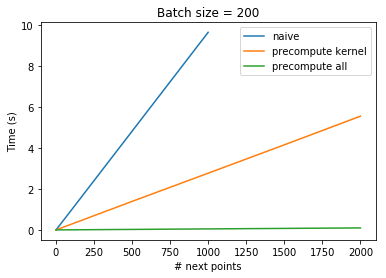

In [22]:
for key in timings:
    plt.plot(n_nexts, timings[key][0], label=key)
    plt.fill_between(n_nexts, timings[key][0] + timings[key][1], timings[key][0] - timings[key][1])

plt.xlabel('# next points')
plt.ylabel('Time (s)')
plt.title(f"Batch size = {n_batch}")
plt.legend()

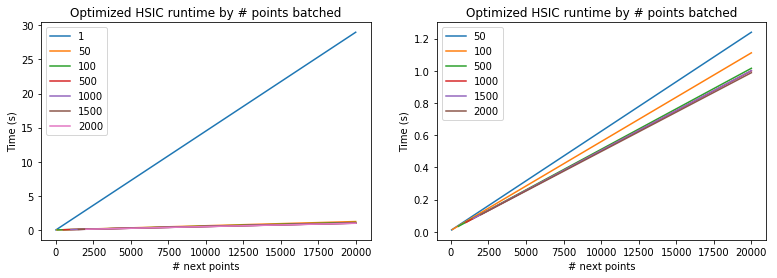

In [110]:
precompute_time = all_timing1.average
times = timings["precompute all"][0] - precompute_time

n_nexts_ = np.concatenate((n_nexts, [5000, 7500, 10_000, 15_000, 20_000]))

plt.figure(figsize=(13, 4))

plt.subplot(121)
for i in range(len(times)):
    plt.plot(n_nexts_[i:], precompute_time + times[i] * n_nexts_[i:] / n_nexts_[i], label=str(n_nexts_[i]))

plt.xlabel('# next points')
plt.ylabel('Time (s)')
plt.title("Optimized HSIC runtime by # points batched")
plt.legend()

plt.subplot(122)
for i in range(1, len(times)):
    plt.plot(n_nexts_[i:], precompute_time + times[i] * n_nexts_[i:] / n_nexts_[i], label=str(n_nexts_[i]))

plt.xlabel('# next points')
plt.ylabel('Time (s)')
plt.title("Optimized HSIC runtime by # points batched")
plt.legend()

In [10]:
n_batch = 200
n_next = 10_000

batch = list(range(n_batch))
next_points = list(range(n_batch, n_batch + n_next))

In [27]:
%%timeit
for i in next_points:
    total_hsic(dimwise_mixrq_kernels(preds[:, batch + [i]]))

19.5 s ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit
batch_kernels = dimwise_mixrq_kernels(preds[:, batch])
for i in next_points:
    point_kernels = dimwise_mixrq_kernels(preds[:, [i]])
    total_hsic(torch.cat((batch_kernels, point_kernels), dim=-1))

5.84 s ± 74.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
batch_stats = precompute_batch_hsic_stats(preds, batch)
point_hsics = compute_point_hsics(preds, next_points, *batch_stats)

107 ms ± 64.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
# CPU: 200 / 2K
batch_stats = precompute_batch_hsic_stats(preds, batch)
point_hsics = compute_point_hsics(preds, next_points, *batch_stats)

5.25 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
# CPU: 200 / 10K
batch_stats = precompute_batch_hsic_stats(preds, batch)
point_hsics = compute_point_hsics(preds, next_points, *batch_stats)

21.1 s ± 353 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
torch.cuda.empty_cache()

# HSIC Validity Testing
To within quite a small tolerance, we're computing exactly the same HSICs as with the unoptimized code.

In [15]:
%%time

acquirable_idx = set(list(range(len(metric))))

batch = [acquirable_idx.pop()]
n_points_parallel = 100
hsics_optimized = []
while len(batch) < batch_size:
    best_idx = None
    best_batch_metric = -float('inf')
    
    batch_stats = precompute_batch_hsic_stats(preds, batch)

    for next_points in torch.tensor(list(acquirable_idx)).split(n_points_parallel):
        hsics = compute_point_hsics(preds, next_points, *batch_stats)
        hsics_optimized.extend(hsics.tolist())
        idx = hsics.argmax()
        hsic = hsics[idx]
        idx = next_points[idx]
        
        batch_metric = metric[idx] - hsic_coeff * hsic

        if batch_metric > best_batch_metric:
            best_batch_metric = batch_metric
            best_idx = idx.item()

    batch.append(best_idx)
    acquirable_idx.remove(best_idx)
    break

CPU times: user 832 ms, sys: 284 ms, total: 1.12 s
Wall time: 1.12 s


In [16]:
%%time

acquirable_idx = set(list(range(len(metric))))

batch = [acquirable_idx.pop()]
hsics_naive = []
while len(batch) < batch_size:
    best_idx = None
    best_batch_metric = -float('inf')
    possible_batch = [*batch, None]

    for i in acquirable_idx:
        possible_batch[-1] = i
        hsic = total_hsic(dimwise_mixrq_kernels(preds[:, possible_batch]))
        hsics_naive.append(hsic)
        batch_metric = metric[i] - hsic_coeff * hsic

        if batch_metric > best_batch_metric:
            best_batch_metric = batch_metric
            best_idx = i
        
        if i % 1000 == 0:
            print(i, end=" ")

    batch.append(best_idx)
    acquirable_idx.remove(best_idx)
    break

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 CPU times: user 27.6 s, sys: 276 ms, total: 27.9 s
Wall time: 27.9 s


In [17]:
hsics_optimized = np.array(hsics_optimized)
hsics_naive = np.array(hsics_naive)

In [18]:
thresh = 0.000001
np.allclose(hsics_optimized, hsics_naive), (abs(hsics_optimized - hsics_naive) <= thresh).all()

(False, True)

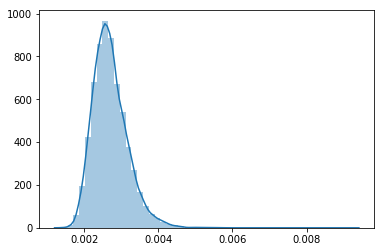

In [19]:
sns.distplot(hsics_optimized);